# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import re
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [3]:
sns.set(font_scale=1.25, style="whitegrid")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device = {device}")

NUM_CORES = os.cpu_count()
if hasattr(os, "sched_getaffinity"):
    # This function is only available on certain platforms. When running with Slurm, it can tell us the true
    # number of cores we have access to.
    NUM_CORES = len(os.sched_getaffinity(0))
print (f"Using {NUM_CORES} cores.")

Using 4 cores.


# Scan Files

First, find all the log files; one for each experiment.

In [4]:
work_dir = Path("../work_dirs")
raw_data = {}
for result_dir in sorted(work_dir.iterdir()):
    if result_dir.is_dir():
        logs = sorted(result_dir.glob("*.log"))
        latest_log = logs[-1]
        raw_data[latest_log.parent.name] = {}
        raw_data[latest_log.parent.name]["log"] = latest_log

Now parse the training trajectory from each log file.

In [5]:
epoch_pattern = re.compile(r"^.+ (Epoch(\(val\))?)\s\[(\d+)\]\[(\d+)(/\d+)?\]\s+(.+)$")

def extract_data(dmap):
    dmap["train_traj"] = []
    with open(dmap["log"]) as f:
        for line in f:
            match = epoch_pattern.match(line)
            if match:
                if match.group(2):
                    # This is a validation row. Add its data to the most recent row.
                    row = dmap["train_traj"][-1]
                    epoch = int(match.group(3))
                    if epoch != row["epoch"]:
                        raise RuntimeError(f"Most recent epoch ({row['epoch']}) does not match validation epoch ({epoch}), in row:\n{line}")
                else:
                    # Create a new row.
                    row = {}
                    row["epoch"] = int(match.group(3))
                    row["batch"] = int(match.group(4))
                    dmap["train_traj"].append(row)

                # Record the metrics in this row.
                for mstr in match.group(6).split(", "):
                    pair = mstr.split(": ")
                    if len(pair) == 2:
                        name, value = pair
                        try:
                            row[name] = int(value)
                        except ValueError:
                            try:
                                row[name] = float(value)
                            except ValueError as e:
                                pass  # value is not parseable, therefore not an actual metric

In [6]:
for expname, dmap in raw_data.items():
    extract_data(dmap)
    if dmap.get("train_traj"):
        dmap["df"] = pd.DataFrame.from_records(dmap["train_traj"])
        dmap["df"]["step"] = range(1, len(dmap["df"]) + 1)
        dmap["df"].set_index(["epoch", "batch", "step"], inplace=True)

Assemble a dataframe with all experiments.

In [7]:
all_dfs = {k: dmap["df"] for k, dmap in raw_data.items() if "df" in dmap}
df = pd.concat(all_dfs.values(), keys=all_dfs.keys(), names=["experiment", "epoch", "batch", "step"])

In [8]:
df

lr  \
experiment                                      epoch batch step             
10m_imagenet_128x8_100e_dery_adamw              1     100   1     0.000017   
                                                      200   2     0.000033   
                                                      300   3     0.000049   
                                                      400   4     0.000065   
                                                      500   5     0.000081   
...                                                                    ...   
90m_imagenet_128x8_100e_dery_adamw_freeze_2conv 100   800   1196  0.000010   
                                                      900   1197  0.000010   
                                                      1000  1198  0.000010   
                                                      1100  1199  0.000010   
                                                      1200  1200  0.000010   

                                                                   time  \
experiment                                      epoch batch step          
10m_imagenet_128x8_100e_dery_adamw              1     100   1     2.085   
                                                      200   2     0.452   
                                                      300   3     0.452   
                                                      400   4     0.452   
                                                      500   5     0.452   
...                                                                 ...   
90m_imagenet_128x8_100e_dery_adamw_freeze_2conv 100   800   1196  0.752   
                                                      900   1197  0.759   
                                                      1000  1198  0.764   
                                                      1100  1199  0.762   
                                                      1200  1200  0.759   

                                                                  data_time  \
experiment                                      epoch batch step              
10m_imagenet_128x8_100e_dery_adamw              1     100   1         0.616   
                                                      200   2         0.001   
                                                      300   3         0.001   
                                                      400   4         0.001   
                                                      500   5         0.001   
...                                                                     ...   
90m_imagenet_128x8_100e_dery_adamw_freeze_2conv 100   800   1196      0.041   
                                                      900   1197      0.224   
                                                      1000  1198      0.227   
                                                      1100  1199      0.117   
                                                      1200  1200      0.191   

                                                                  memory  \
experiment                                      epoch batch step           
10m_imagenet_128x8_100e_dery_adamw              1     100   1       5917   
                                                      200   2       5917   
                                                      300   3       5917   
                                                      400   4       5917   
                                                      500   5       5917   
...                                                                  ...   
90m_imagenet_128x8_100e_dery_adamw_freeze_2conv 100   800   1196   15361   
                                                      900   1197   15361   
                                                      1000  1198   15361   
                                                      1100  1199   15361   
                                                      1200  1200   15361   

                                                                

# Plotting

In [9]:
df.loc[(~df["accuracy_top-1"].isna()) &
       (df.index.get_level_values("epoch") == df.index.get_level_values("epoch").max())]

,,,,lr,time,data_time,memory,loss,accuracy_top-1,accuracy_top-5
experiment,epoch,batch,step,,,,,,,
10m_imagenet_128x8_100e_dery_adamw,100,1200,1200,0.00001,0.453,0.001,5918,2.9892,76.646,93.220
10m_imagenet_128x8_100e_dery_adamw_freeze,100,1200,1200,0.00001,0.708,0.467,5821,4.9294,45.232,69.400
10m_imagenet_128x8_100e_dery_adamw_freeze_2conv,100,1200,1200,0.00001,0.345,0.001,5951,4.9496,45.060,69.156
30m_half_cnn_imagenet_100e_frozen,100,1200,1200,0.00001,0.720,0.003,4697,4.9274,39.640,65.142
30m_half_cnn_imagenet_100e_frozen_2layer,100,1200,1200,0.00001,0.695,0.002,4976,4.8916,39.908,65.492
30m_imagenet_100e_frozen_2layer,100,1200,1200,0.00001,0.724,0.002,25826,4.4841,54.192,78.312
30m_imagenet_128x8_100e_dery_adamw_freeze,100,1200,1200,0.00001,0.742,0.004,7518,4.1843,60.702,82.828
30m_imagenet_128x8_100e_dery_adamw_freeze_2conv,100,1200,1200,0.00001,0.736,0.001,7767,4.2029,61.682,83.702
50m_imagenet_128x8_100e_dery_adamw_freeze,100,2500,2500,0.00001,0.535,0.002,7475,3.6526,71.418,90.368


In [10]:
# Group 1: size
# Group 2: model detail
# Group 3: dataset
# Group 4: extraneous
# Group 5: num epochs
# Group 6: extraneous
# Group 7: adapter type
# Group 8: "layer" or "conv"
model_pattern = re.compile(r"^(\d+m)_(.*?)_?(imagenet)_(.*?)_?(\d+)e_(.*?)(_2(layer|conv))?$")


def model_type(expname):
    match = model_pattern.match(expname)
    if not match:
        raise RuntimeError(f"Unrecognized experiment name pattern: {expname}")
    model_name = match.group(1)
    if match.group(2):
        model_name += " " + match.group(2)
    return model_name


def adapter_type(expname):
    match = model_pattern.match(expname)
    if match.group(7):
        return "2-layer"
    else:
        return "1-layer"


exp_names = df.index.get_level_values("experiment")
df["model"] = [model_type(e) for e in exp_names]
df["adapter"] = [adapter_type(e) for e in exp_names]

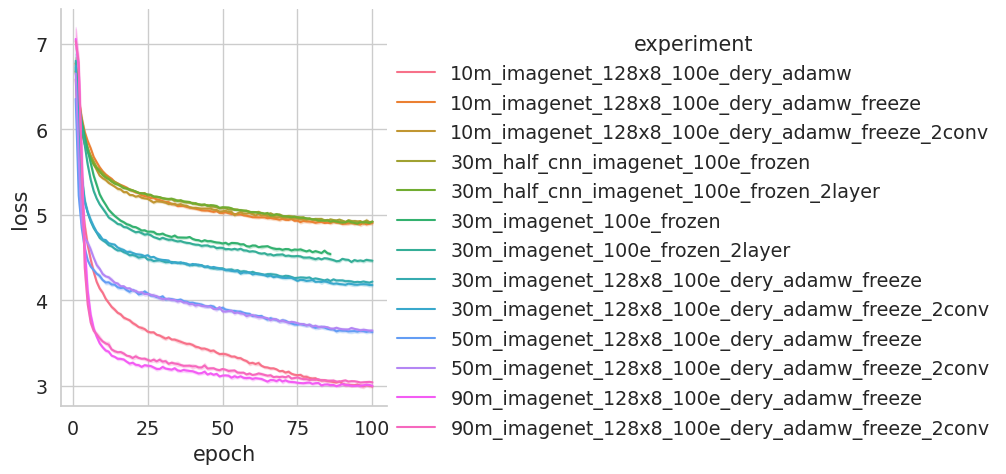

In [11]:
sns.relplot(df, kind="line", x="epoch", y="loss", hue="experiment")